In [1]:
%%capture
!pip install monai
!pip install pynrrd
!pip install torchsummary

In [2]:
from monai.data import Dataset
from monai.data import DataLoader, decollate_batch
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    LoadImage,
    MapTransform,
    NormalizeIntensityd,
    NormalizeIntensity,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    Resized,
    Resize,
    RandGaussianNoised,
    RandBiasFieldd,
    RandAdjustContrastd,
    RandGaussianSmoothd,
    RandRicianNoised,
    CropForegroundd,
    CropForeground,
    RandRotated,
    Rotate90d,
    Flipd,
    ScaleIntensityd,
    CenterSpatialCropd,
    KeepLargestConnectedComponent,
    FillHoles
)
import torch
from torch import nn
import torch.nn.functional as F
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import torch
from tqdm import tqdm
from torchvision.models import convnext_tiny, swin_t
from torchvision.models import efficientnet_v2_s
from sklearn.metrics import roc_auc_score
from sklearn.metrics  import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import brier_score_loss
import nrrd
from monai.losses import DiceFocalLoss
from monai.metrics import DiceMetric
from matplotlib.colors import ListedColormap
green = ListedColormap(['k', 'g'])
red = ListedColormap(['k', 'r'])
import pickle as pkl

2024-04-03 10:32:52.387034: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 10:32:52.387144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 10:32:52.738198: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
with open('/kaggle/input/scl-preprocess/dataset.pkl', 'rb') as file:
    ds = pkl.load(file)

In [4]:
ds[0]['label'].shape

torch.Size([3, 128, 128, 64])

In [5]:
preprocessing = Compose([
#         Resized(keys=['image'], spatial_size=(128, 128, 64), mode=['trilinear']),
#         Resized(keys=['label'], spatial_size=(128, 128, 64), mode=['nearest-exact']),
        # Rotate90d(k=3, keys=['image', 'label']),
        # Rotate90d(k=1, keys=['image', 'label'], spatial_axes = (1, 2)),
        # Rotate90d(k=3, keys=['image', 'label']),
        # Rotate90d(k=2, keys=['image', 'label'], spatial_axes = (0, 2)),
        # Flipd(keys=['image'], spatial_axis=1), #because jpeg files don't have correct orientation metadata
        # ScaleIntensityd(keys='image', dtype=None), #for some reason slows preprocessing down
        NormalizeIntensityd(keys="image"), #using mean and sd values from PyTorch doc
        # RandScaleIntensityd(keys="image", factors=0.1, prob=0.5),
        # RandGaussianNoised(keys='image', prob=0.5, std=0.05),
        # RandBiasFieldd(keys='image', degree=2),
        # RandAdjustContrastd(keys='image', prob=0.3, gamma=(0.95, 1.05)),
        # RandGaussianSmoothd(keys='image', prob=0.05, sigma_x=(0.95, 1.05), sigma_y=(0.95, 1.05)),
    ])

aug = Compose([
#         ScaleIntensityd(keys='image', dtype=None), #for some reason slows preprocessing down
#         NormalizeIntensityd(keys="image"), #using mean and sd values from PyTorch doc
        RandScaleIntensityd(keys="image", factors=0.1, prob=0.5),
        RandGaussianNoised(keys='image', prob=0.5, std=0.05),
        RandBiasFieldd(keys='image', degree=2),
        RandAdjustContrastd(keys='image', prob=0.3, gamma=(0.95, 1.05)),
        RandGaussianSmoothd(keys='image', prob=0.05, sigma_x=(0.95, 1.05), sigma_y=(0.95, 1.05)),
    ])

In [6]:
dataset = [preprocessing(i) for i in ds]

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
train_ds = Dataset(data=dataset[:14], transform=aug)
val_ds = Dataset(data=dataset[-3:], transform=None)
train_loader = DataLoader(dataset=train_ds, num_workers=4, batch_size=4, shuffle=True, pin_memory=True, pin_memory_device=device)
val_loader = DataLoader(dataset=val_ds, num_workers=4, batch_size=4, shuffle=False, pin_memory=True, pin_memory_device=device)

In [9]:
len(train_ds), len(val_ds)

(14, 3)

# Model

In [10]:
MODEL_DIR = '/kaggle/working/'

In [11]:
from monai.networks.nets import SegResNet
from monai.networks.nets import SwinUNETR
from monai.networks.nets import AHNet

In [12]:
train_ds[0]['label'].shape

torch.Size([3, 128, 128, 64])

In [13]:
max_epochs = 400
val_interval = 2
model = SegResNet(out_channels = 3, dropout_prob = 0.2, norm = 'BATCH')
model = nn.DataParallel(model).to(device)

# model = SwinUNETR(img_size=(96,96,64), in_channels=1, out_channels=2, feature_size=24).to(device)
# model = AHNet(out_channels=2, psp_block_num=2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), 2e-3, weight_decay=1e-4, amsgrad=True)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
dice_metric = DiceMetric(include_background=True, reduction="mean")
loss_function = DiceFocalLoss(squared_pred=True, to_onehot_y=False, sigmoid=True, lambda_focal=0.5)
post_trans = Compose([
    Activations(sigmoid=True),
    AsDiscrete(threshold=0.5),
#     KeepLargestConnectedComponent(connectivity=3),
#     FillHoles(connectivity=3),
    ])

# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [14]:
torch.cuda.empty_cache()

In [15]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels =batch_data["image"].to(device), batch_data["label"].to(device),
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )

        lr_scheduler.step()
#     print (f'''LR:{optimizer.param_groups[0]['lr']}''')
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.inference_mode():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = model(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            dice_metric.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(
                    model.state_dict(),
                    os.path.join(MODEL_DIR, f"best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/400
1/3, train_loss: 1.0438, step time: 7.3242
2/3, train_loss: 1.0061, step time: 0.5209
3/3, train_loss: 1.0033, step time: 0.6022
4/3, train_loss: 1.0119, step time: 1.0091
epoch 1 average loss: 1.0163
time consuming of epoch 1 is: 10.2085
----------
epoch 2/400
1/3, train_loss: 1.0008, step time: 0.5756
2/3, train_loss: 1.0014, step time: 0.5340
3/3, train_loss: 0.9739, step time: 0.5497
4/3, train_loss: 0.9963, step time: 0.3793
epoch 2 average loss: 0.9931
saved new best metric model
current epoch: 2 current mean dice: 0.0604
best mean dice: 0.0604 at epoch: 2
time consuming of epoch 2 is: 4.5654
----------
epoch 3/400
1/3, train_loss: 0.9463, step time: 0.5335
2/3, train_loss: 0.9561, step time: 0.5476
3/3, train_loss: 0.9879, step time: 0.5416
4/3, train_loss: 0.9421, step time: 0.3674
epoch 3 average loss: 0.9581
time consuming of epoch 3 is: 2.5815
----------
epoch 4/400
1/3, train_loss: 0.9188, step time: 0.5644
2/3, train_loss: 0.9589, step time: 0.5732
3

In [16]:
best_param = torch.load('/kaggle/working/best_metric_model.pth')
model.load_state_dict(best_param)

<All keys matched successfully>

# Visualization

In [17]:
post_trans = Compose([
    Activations(sigmoid=True),
#     AsDiscrete(threshold=0.5),
#     KeepLargestConnectedComponent(connectivity=3),
#     FillHoles(connectivity=3),
    ])


In [18]:
preds = []
with torch.inference_mode():
    for subject in val_ds:
        pred = model(subject['image'].unsqueeze(0).to(device))
        preds.append(post_trans(pred).squeeze().cpu())

In [19]:
len(val_ds)

3

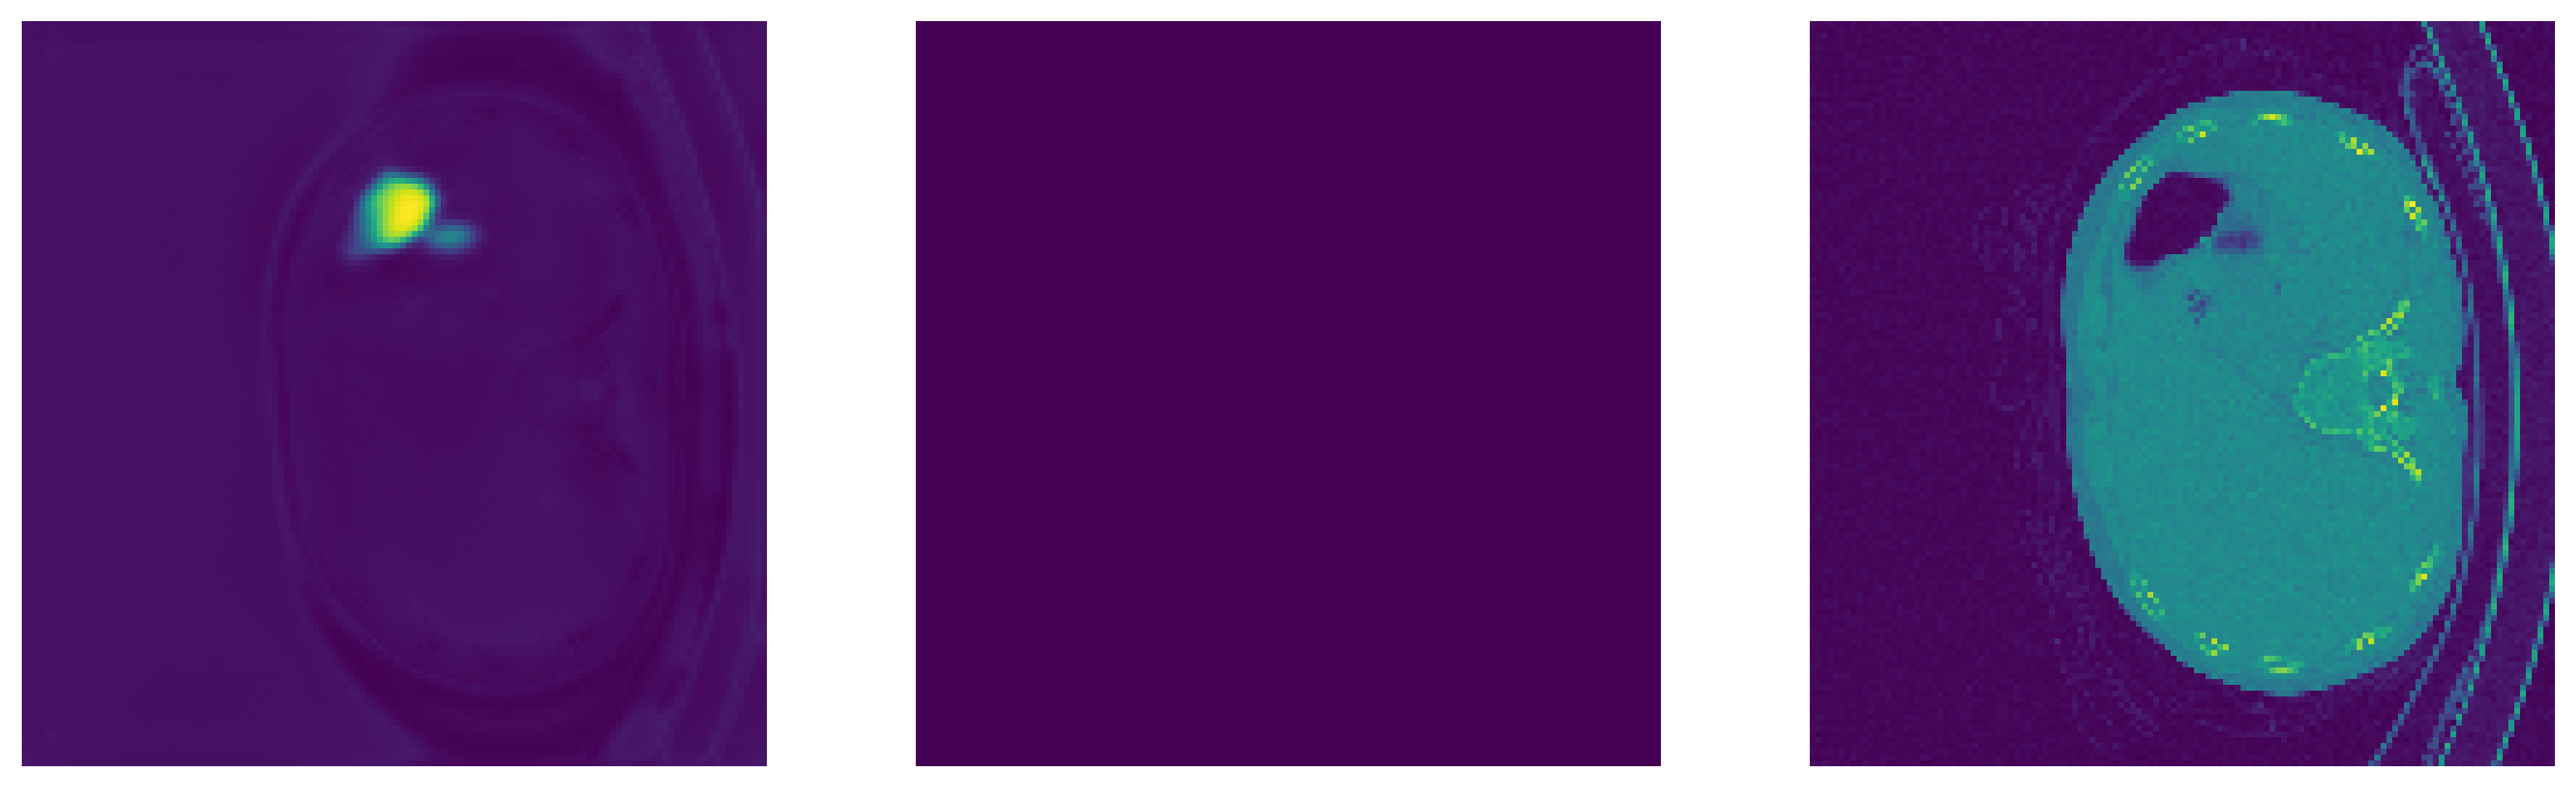

In [20]:
index = 2
# image = val_ds[index]['image']
image = dataset[index+14]['image']
label = val_ds[index]['label']
pred = preds[index]
fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=300)
ax[0].imshow(pred[0, :, :, 16])
ax[1].imshow(label[0, :, :, 16])
ax[2].imshow(image[0, :, :, 16])

# Turn off y-axis and x-axis labels for all axes
for axis in ax:
    axis.set_axis_off()

plt.show()